In [1]:
import project_metrics.project_metrics as metrics
import numpy as np
import pandas as pd
import pickle
from os.path import exists

2022-09-30 00:18:09.283797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 00:18:09.635077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 00:18:09.635100: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-30 00:18:09.679999: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 00:18:10.636235: W tensorflow/stream_executor/platform/de

In [2]:
df_train = pd.read_csv("Assets/train.csv")
df_val= pd.read_csv("Assets/val.csv")
df_test = pd.read_csv("Assets/test.csv")

In [3]:
df_train.drop("INDEX", inplace=True, axis =1)
df_val.drop("INDEX", inplace=True, axis =1)
df_test.drop("INDEX", inplace=True, axis =1)

df_train.drop("Unnamed: 0", inplace=True, axis =1)
df_val.drop("Unnamed: 0", inplace=True, axis =1)
df_test.drop("Unnamed: 0", inplace=True, axis =1)

df_train.drop("IND_BOM_1_2", inplace=True, axis =1)
df_val.drop("IND_BOM_1_2", inplace=True, axis =1)
df_test.drop("IND_BOM_1_2", inplace=True, axis =1)

In [4]:
y_train = df_train["IND_BOM_1_1"].values
y_val = df_val["IND_BOM_1_1"].values
y_test = df_test["IND_BOM_1_1"].values

In [5]:
df_train.drop("IND_BOM_1_1", inplace=True, axis =1)
df_val.drop("IND_BOM_1_1", inplace=True, axis =1)
df_test.drop("IND_BOM_1_1", inplace=True, axis =1)

In [6]:
x_train = df_train.values
x_val = df_val.values
x_test = df_test.values

In [7]:
x_train.shape

(255098, 243)

# Final Project

## MLP

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import keras

MODELS_PATH = "Models/MLP"
HISTORY_PATH = f"{MODELS_PATH}/history"
MODEL_PATH = f"{MODELS_PATH}/model"

### Experimento1

In [9]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(16, activation='relu', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='mean_squared_error')

history_file = HISTORY_PATH + "1.npy"
model_file = MODEL_PATH + "1"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=10_000, callbacks=[EarlyStopping(patience=10,verbose=1)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

Model was already trained


2022-09-30 00:18:27.026734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 00:18:27.026911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 00:18:27.027147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-30 00:18:27.027196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-30 00:18:27.027240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

   1/3041 [..............................] - ETA: 6:06

2022-09-30 00:18:27.450258: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94575600 exceeds 10% of free system memory.


3041/3041 [==============================] - 2s 739us/step
Matriz de confusão no conjunto de teste:


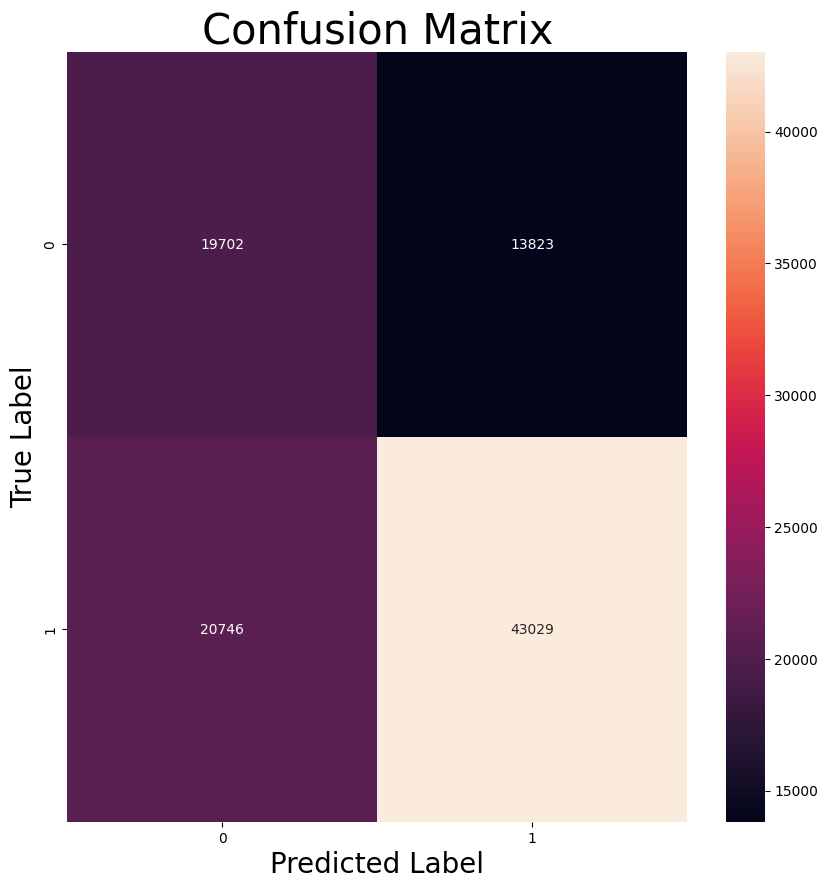


Train Loss:       0.2187
Validation Loss:  0.2214

Performance no conjunto de teste:


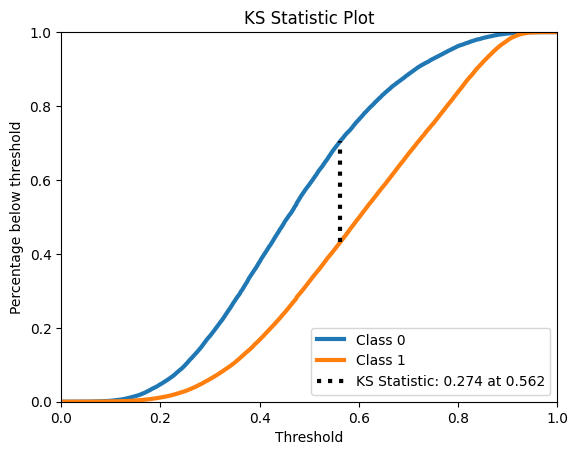


Accuracy:         0.6447
Recall:           0.6747
Precision:        0.7569
F1:               0.7134
AUROC:            0.6887
AUPR:             0.8014


In [10]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento2

In [11]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(256, activation='relu', input_dim=input_dim))
classifier.add(Dense(128, activation='relu', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='mean_squared_error')

history_file = HISTORY_PATH + "2.npy"
model_file = MODEL_PATH + "2"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=10_000, callbacks=[EarlyStopping(patience=20,verbose=1,restore_best_weights=True)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

Model was already trained


 110/3041 [>.............................] - ETA: 2s

2022-09-30 00:18:31.959175: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94575600 exceeds 10% of free system memory.


3041/3041 [==============================] - 3s 926us/step
Matriz de confusão no conjunto de teste:


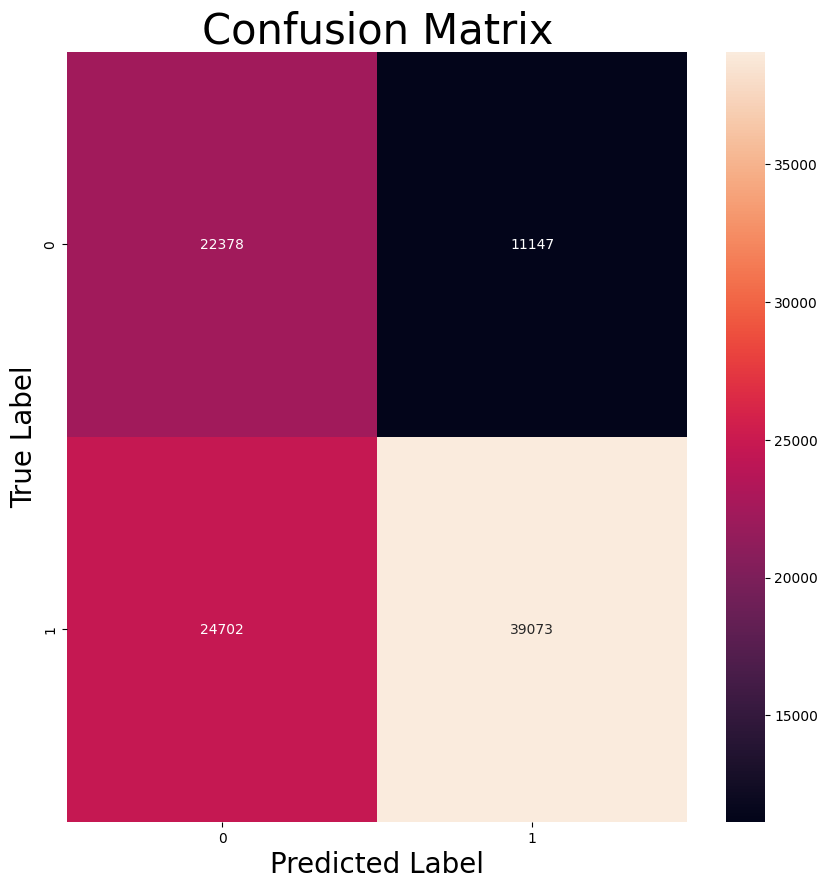


Train Loss:       0.2206
Validation Loss:  0.2213

Performance no conjunto de teste:


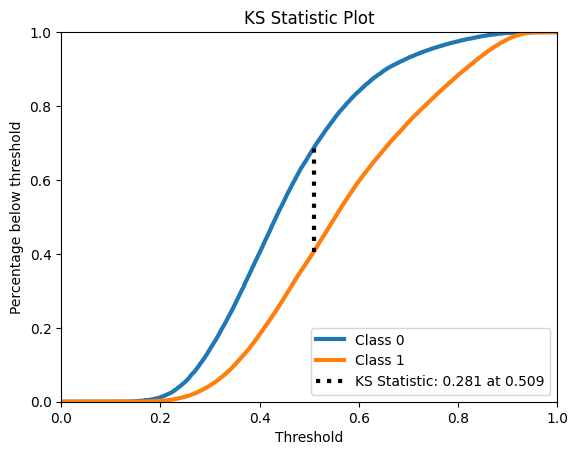


Accuracy:         0.6316
Recall:           0.6127
Precision:        0.7780
F1:               0.6855
AUROC:            0.6921
AUPR:             0.8042


In [12]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Experimento3

In [13]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(512, activation='sigmoid', input_dim=input_dim))
classifier.add(Dense(256, activation='sigmoid', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))

optimizer=keras.optimizers.SGD( learning_rate=0.01)
classifier.compile(optimizer=optimizer, loss='mean_squared_error')

history_file = HISTORY_PATH + "3.npy"
model_file = MODEL_PATH + "3"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=10_000, callbacks=[EarlyStopping(patience=20,verbose=1,restore_best_weights=True)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

Epoch 1/10000


2022-09-30 00:18:36.822806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 247955256 exceeds 10% of free system memory.


7949/7972 [============================>.] - ETA: 0s - loss: 0.2488

2022-09-30 00:18:53.759515: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 123976656 exceeds 10% of free system memory.


7972/7972 [==============================] - 21s 3ms/step - loss: 0.2488 - val_loss: 0.2468
Epoch 2/10000
7972/7972 [==============================] - 20s 2ms/step - loss: 0.2448 - val_loss: 0.2441
Epoch 3/10000
7972/7972 [==============================] - 21s 3ms/step - loss: 0.2403 - val_loss: 0.2395
Epoch 4/10000
7972/7972 [==============================] - 20s 2ms/step - loss: 0.2360 - val_loss: 0.2337
Epoch 5/10000
7972/7972 [==============================] - 20s 2ms/step - loss: 0.2332 - val_loss: 0.2321
Epoch 6/10000
7972/7972 [==============================] - 20s 3ms/step - loss: 0.2314 - val_loss: 0.2312
Epoch 7/10000
7972/7972 [==============================] - 20s 3ms/step - loss: 0.2304 - val_loss: 0.2293
Epoch 8/10000
7972/7972 [==============================] - 20s 3ms/step - loss: 0.2296 - val_loss: 0.2287
Epoch 9/10000
7972/7972 [==============================] - 20s 3ms/step - loss: 0.2289 - val_loss: 0.2288
Epoch 10/10000
7972/7972 [==============================] - 

KeyboardInterrupt: 

In [ ]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

NameError: name 'classifier' is not defined

# Experimento4

In [ ]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(512, activation='tanh', input_dim=input_dim))
classifier.add(Dense(256, activation='tanh', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))

optimizer=keras.optimizers.SGD( learning_rate=0.01)
classifier.compile(optimizer=optimizer, loss='mean_squared_error')

history_file = HISTORY_PATH + "4.npy"
model_file = MODEL_PATH + "4"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=10_000, callbacks=[EarlyStopping(patience=20,verbose=1,restore_best_weights=True)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

In [ ]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

# Experimento5

In [ ]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(1024, activation='tanh', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='mean_squared_error')

history_file = HISTORY_PATH + "5.npy"
model_file = MODEL_PATH + "5"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=10_000, callbacks=[EarlyStopping(patience=20,verbose=1)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

In [ ]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)